## 犬と猫を分類するモデルを構築

### 1. 画像の読み込み

まずは簡単に画像の読み込みの方法を紹介します。

In [1]:
import warnings
warnings.filterwarnings('ignore')

`train` のフォルダに入っている画像を読み込みます。
`glob` を利用すると簡単にファイルを検索できます。

In [2]:
from glob import glob

In [3]:
dog_filepaths = glob('train/dog/*.jpg')
cat_filepaths = glob('train/cat/*.jpg')

In [4]:
# 先頭から３件の表示
dog_filepaths[:3]

['train/dog/74.jpg', 'train/dog/15.jpg', 'train/dog/54.jpg']

In [5]:
# 先頭から３件の表示
cat_filepaths[:3]

['train/cat/74.jpg', 'train/cat/15.jpg', 'train/cat/54.jpg']

では、その中の画像１枚にまず焦点を当てて取り扱い方を見ていきましょう。

Python では Pillow というパッケージで簡単に画像を扱うことができます。込み入った処理は OpenCV を使うと良いでしょう。

今回は単純な読み込み程度ですので Pillow でOKです。

In [6]:
# Windows
# pip install Pillow    or   python -m pip install Pillow

# macOS
# pip3 install Pillow

In [7]:
from PIL import Image

In [8]:
# 画像の読み込み（犬の１番目の画像）
img = Image.open(dog_filepaths[0])

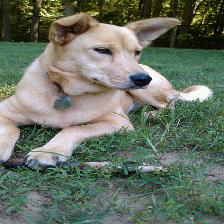

In [9]:
img

In [10]:
# 型の確認
type(img)

PIL.JpegImagePlugin.JpegImageFile

上記の通り、Pillow 独自の方を持っているため、計算で扱う場合には numpy の ndarray に変換しておきましょう。

In [11]:
import numpy as np

In [12]:
# numpy の形式に変換
img = np.array(img)

In [13]:
# 変換後の img での型の確認
type(img)

numpy.ndarray

In [14]:
# サイズの確認
img.shape

(224, 224, 3)

In [15]:
# データ型の確認 => unsigned int 8 => 0~255 の整数で表現される
img.dtype

dtype('uint8')

In [16]:
# （必要に応じて）数値の確認
#img

### 2. クラスラベルの割り振り

画像の読み込み方がわかったため、クラスのラベルを割り振っていきましょう。

In [17]:
# 入力値:x, 目標値: t
x, t = [], []

In [18]:
# 犬
for filepath in dog_filepaths:
    img = Image.open(filepath)
    img = np.array(img)
    x.append(img)
    t.append(np.array(0))  # 犬は 0 とする

In [19]:
# 猫
for filepath in cat_filepaths:
    img = Image.open(filepath)
    img = np.array(img)
    x.append(img)
    t.append(np.array(1))  # 猫は 0 とする

In [20]:
# 格納された枚数
len(x), len(t)

(300, 300)

In [21]:
# 全体を numpy の形式に変換
x = np.array(x)  # f は float32
t = np.array(t)  # i は int32

In [22]:
# 300(枚), 224(height), 224(width), 3(channels)
x.shape

(300, 224, 224, 3)

In [23]:
t.shape

(300,)

x の値の範囲を正規化しておくと学習が効率的に進むことが多いため、こちらも行なっておきましょう。学習係数などを調整する場合など、必ず必要ではありません。

In [24]:
# 特徴量の正規化 (0~1の範囲に)
x = x / 255

### 3. 訓練データと検証データに分割

tensorflow では訓練データ (train) と検証データ (val) を分ける機能がないため、scikit-learn の `train_test_split` を利用します。

なお、テストデータ (test) は私の手元にしかないため、手持ちのデータの中で以下にテストデータを模擬的に表現できるかのために検証データがあります。精度を高めたいときには**交差検証法 (cross validation)** も選択肢としてあるため、こちらも必要であれば挑戦してみましょう。

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# train : val = 0.7 : 0.3 の割合で分割する
train_x, val_x, train_t, val_t = train_test_split(x, t, train_size=0.7, random_state=0)

In [27]:
# サイズの確認（訓練データ）
train_x.shape, train_t.shape

((210, 224, 224, 3), (210,))

In [28]:
# サイズの確認（検証データ）
val_x.shape, val_t.shape

((90, 224, 224, 3), (90,))

### 4. モデルを定義

今回は非常にシンプルな構成の CNN でモデルを構築します。あまり良い精度が出ないようにしてあるため、ここのモデルの構造を工夫して精度を高めましょう。

ヒント
- VGG, ResNet, MobileNet
- ファインチューニング

複雑なモデルを構築する場合には GPU がないと遅い場合もあるため、[こちらの手順](https://www.kikagaku.ai/tutorial/guide_for_beginners/learn/platform_environment) を参考に Google Colab を使ってみると良いでしょう。

In [29]:
import tensorflow as tf

In [30]:
# バージョンの情報
tf.__version__

'2.2.0'

モデル構築の際に乱数のシードも固定しておきましょう。

In [31]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

tensorflow のモデルの定義に必要なモジュールを読み込みます

In [32]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow_hub as hub

In [33]:
num_classes = 2

feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"

# B0のinput sizeは(224, 224)が推奨
# 推奨のwidth/heightについてはこちらのページをご覧ください https://tfhub.dev/google/collections/efficientnet/1
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3)
                                        #, trainable=True
                                        )



In [34]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    Dense(128, activation='relu'),
    Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              5330564   
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 5,458,950
Trainable params: 128,386
Non-trainable params: 5,330,564
_________________________________________________________________


以下のようなモデルを定義していきましょう。

- Original: (224, 224, 3)
- => Convolution (Relu) => (224, 224, 6)
- => Half Pooling => (112, 112, 6)
- => ベクトル化 (112×112×6)
- => 全結合層 (112×112×6 => 100), Relu
- => 全結合層 (100 => 2), Softmax

In [36]:
# モデルの定義
# model = models.Sequential([
#     # Convolution
#     layers.Conv2D(3, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
#     # Pooling
#     layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     # ベクトル化 (Flatten)
#     layers.Flatten(),
#     # 全結合層
#     layers.Dense(100, activation='relu'),
#     # 全結合層
#     layers.Dense(2, activation='softmax') 
# ])

### 5. モデルの学習

Tenrsoflow では定義したモデルをコンパイルする必要がありました。最適化のアルゴリズムを確率的勾配降下法 (SGD) として選択します。

ここのアルゴリズムの選択と学習係数の設定も精度向上のポイントですので、[こちらの記事](https://www.tensorflow.org/guide/keras/train_and_evaluate) などを参考にしながら進めてみましょう。

In [37]:
# モデルのコンパイル
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),#,SGD #tf.keras.optimizers.Adam(learning_rate=0.01),rmsprop
    #optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',#binary_crossentropy
    metrics=['accuracy']
)

In [38]:
# モデルの学習
history = model.fit(
    train_x, train_t,
    batch_size=32,
    epochs=20,
    validation_data=(val_x, val_t)
)

Epoch 1/20
7/7 [==============================] - 43s 6s/step - loss: 0.5884 - accuracy: 0.8381 - val_loss: 0.4233 - val_accuracy: 0.9444
Epoch 2/20
7/7 [==============================] - 1s 151ms/step - loss: 0.2774 - accuracy: 0.9619 - val_loss: 0.1688 - val_accuracy: 0.9667
Epoch 3/20
7/7 [==============================] - 1s 150ms/step - loss: 0.0917 - accuracy: 0.9857 - val_loss: 0.1145 - val_accuracy: 0.9667
Epoch 4/20
7/7 [==============================] - 1s 149ms/step - loss: 0.0347 - accuracy: 0.9905 - val_loss: 0.1181 - val_accuracy: 0.9667
Epoch 5/20
7/7 [==============================] - 1s 149ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 0.9556
Epoch 6/20
7/7 [==============================] - 1s 148ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1865 - val_accuracy: 0.9556
Epoch 7/20
7/7 [==============================] - 1s 152ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.2202 - val_accuracy: 0.9556
Epoch 8/20
7/7 [======

train に関して accuracy が 0.96, validation に関しては accuracy が 0.65 となっており、**過学習 (overfitting)** が生じていることがわかります。

この辺りも踏まえて、予測の精度を上げられるように色々な手法に挑戦してみましょう。比較的簡単なところでは以下を調整してみると良いでしょう。

- モデルの構成（VGG, ResNet, MobileNet など）
- ファイチューニング
- 最適化アルゴリズムの選択
- 学習係数

### 5. モデルの保存

推論にて使用するために学習済みモデルをファイルに出力しましょう。

In [55]:
# HDF5 という形式で保存（TensorFlowではこちらを用いるようです）
model.save('dog_cat_cnn.h5')
saved_model_path = 'dog_cat_cnn_saved.pb'

tf.keras.models.save_model(model, saved_model_path,save_format="tf")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: dog_cat_cnn_saved.pb/assets


INFO:tensorflow:Assets written to: dog_cat_cnn_saved.pb/assets


In [ ]:
!python -m tf2onnx.convert --saved-model dog_cat_cnn_saved.pb --output model.onnx

これで作業フォルダの中に `dog_cat_cnn.h5` というファイルが出力できていれば成功です。

### 6. 学習済みモデルで推論

学習に関しては、上記までで終了となりますが、この後の推論 (inference) サーバーへデプロイの前に保存した学習済みモデルを用いた推論の方法について試しておきましょう。

In [40]:
from tensorflow.keras.models import load_model

In [41]:
# 保存した学習済みモデルを読み込み
# model_inference = load_model('dog_cat_cnn.h5')

model_inference = tf.keras.models.load_model('dog_cat_cnn.h5',custom_objects={'KerasLayer':hub.KerasLayer})

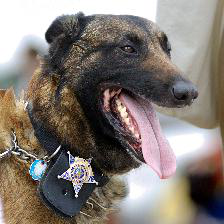

In [61]:
img = Image.open('train/dog/21.jpg')
img

In [62]:
x = np.array(img, 'f')  # float32 に変換
x.shape

(224, 224, 3)

推論時は (224, 224, 3) ではなく、1 サンプルでも (1, 224, 224, 3) としておく必要があります。

In [63]:
# np.newaxis で次元をひとつ追加
x = x[np.newaxis]
x.shape

(1, 224, 224, 3)

予測値は `predict` で求められます。ただし、返ってくる結果はラベルの値ではなく、それぞれのクラスに属する確率です。これを**信頼度 (confidence)** といいます。

In [64]:
y_prob = model_inference.predict(x)[0]
y_prob

array([9.9998832e-01, 1.1718276e-05], dtype=float32)

信頼度が最も高いクラスを選択します。

In [65]:
y = np.argmax(y_prob)
y

0

犬が 0 番目であったため、正しく予測できていることがわかります。予測の流れはここまでとなります。

### 7. ONNX形式で出力

ONNX は TensorFlow や PyTorch 問わず、モデルの形式を標準化するプロジェクトです。  
最近では、こちらの形式に統一しておくほうが汎用性が高くなっているため、推論サーバーでは ONNX 形式を使用します。

onnxruntime では通常よりも速度が速いと言われています。

In [66]:
# Windows
# !pip install onnxruntime   or   !python -m pip install onnxruntime

# macOS
# pip3 install onnxruntime

In [67]:
import onnxruntime
onnxruntime.__version__

'1.3.0'

In [68]:
# Windows
# !pip install keras2onnx  or   !python -m pip install keras2onnx

# macOS
# pip3 install keras2onnx

In [69]:
import keras2onnx
keras2onnx.__version__

'1.7.0'

In [70]:
import tf2onnx
tf2onnx.__version__

'1.6.2'

In [71]:
# Keras -> ONNX の変換
#onnx_model = keras2onnx.convert_keras(model, model.name)
#onnx_model = tf2onnx.tfonnx.process_tf_graph(model,verbose=True)

In [72]:
# モデルを保存
#keras2onnx.save_model(onnx_model, 'dog_cat_cnn.onnx')

In [73]:
# モデルの読み込み
#session = onnxruntime.InferenceSession('dog_cat_cnn.onnx')
session = onnxruntime.InferenceSession('model.onnx')

In [74]:
# 推論に必要な構造の抽出
session.get_modelmeta()
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [75]:
input_name, output_name

('keras_layer_input:0', 'Identity:0')

In [76]:
# 推論
y_probs = session.run([output_name], {input_name: x})[0]
y_probs

array([[9.9998832e-01, 1.1718265e-05]], dtype=float32)

In [77]:
# ラベル
y = np.argmax(y_prob)
y

0